# Introduction

### I am a consultant for a fictional real-estate investment firm. The firm has asked me to find out what are the top 5 zip codes for me to invest in.


## How does this help

Realestate has conventionally been quite a traditional market. Experience and qualitative knowledge has been a large driver in investment decisions in the indisutry. 

However, episodes like the financial crisis of 2007/08 along with many other episodes have shown that it isnt enough to assume that realestate will always go up. 

In addition to this the realestate market is getting ever more competitive. With inflation rising and the value of money going down investors are looking for alternative assets to store money in. Realestate is at the forefront of this race. Thus, inorder to make make the best decisions in a competitive space great analysis must be done before investment decision are done.

Being able to leverage the plethora of data on the realestate market is vital. Even if the conventional wisdom of 'realestate is always goign to go up' is assumed PE funds typically target a 25%IRR and a 2.5X mom over a 5-10 year time frame. This is hard to achieve thus leveraging data to make sound decisions is important.


## My role in this

Given the necessity to use data to make investment decisions i have the role to analyse the data available to suggest regions which would be good for investment. My goal is to narrow down the search to a 5 zipcodes which an investment firm could spend time and energy looking into before deciding exactly where and what to invest in.






# Step 1: Load the Data/Filtering for Chosen Zipcodes

Loading all the packages i will need

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.head(5)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.dtypes

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
               ...  
2017-12        int64
2018-01        int64
2018-02        int64
2018-03        int64
2018-04        int64
Length: 272, dtype: object

In [5]:
test = (df[df['RegionName'] == 3038])
test

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2460,59003,3038,Derry,NH,Boston,Rockingham,2461,106000.0,106300.0,106600.0,...,281700,284000,286300,288300,290600,292800,294400,295900,298800,301700


Seemingly zipcodes that start with a zero are made into 4 digit zipcodes. This should however still not be an issue as they will all still remain unique

In [6]:
test1 = (df[df['RegionName'] == 03038])
test1

SyntaxError: invalid token (<ipython-input-6-74b26ee24967>, line 1)

In [ ]:
df.dtypes

I start by thinking of which zipcodes i would like to build a time series model for. 

I decide to filter the data based on zipcode. 

I take the top 20% of zip codes as this would give me property that is more urbanized. This is preferable to me as an investor. 



In [7]:
print(df.SizeRank.describe(),'\n')
sr_20 = df.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {sr_20}')
zc_top20= df[df['SizeRank']<sr_20].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(zc_top20)}')

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64 

Size Rank 20% cutoff value: 2945.4
Amount of zipcodes: 2945


From the top 20% I decide to filter it down even more. I decide to choose properties that are 10% abore the average value (of the last 12 months value) and 15% below the average value (of the last 12 months value). This is becausae i dont want values that are too far in the extremities. As an investor properties that are too expensive and too cheap are not preferable as they may bare other risks. 

In [8]:
zc_top20['yr_avg']=zc_top20.iloc[:,-12:].mean(skipna=True, axis=1)
print(zc_top20['yr_avg'].describe(),'\n')
q_60 = zc_top20['yr_avg'].quantile(q=0.60)
print(f'Average Value 60% cutoff value: {round(q_60,2)}')
q_35 = zc_top20['yr_avg'].quantile(q=0.35)
print(f'Average Value 35% cutoff value: {round(q_35,2)}')
zc_pref= zc_top20[(zc_top20['yr_avg']<q_60) & (zc_top20['yr_avg']>q_35)]
print(f'Amount of zipcodes: {len(zc_pref)}')

count    2.945000e+03
mean     3.730666e+05
std      5.836511e+05
min      3.632500e+04
25%      1.691333e+05
50%      2.484083e+05
75%      3.978333e+05
max      1.858138e+07
Name: yr_avg, dtype: float64 

Average Value 60% cutoff value: 290211.67
Average Value 35% cutoff value: 198641.67
Amount of zipcodes: 736


I then calculate the ROI this is calculated as 

(the price in the first month of data)/(minus the price in the last month of data) - 1

I also calculate the SD of monthly values and the coefficient of variance

In [9]:
zc_pref['ROI']= (zc_pref['2018-04']/zc_pref['1996-04'])-1
zc_pref['std']=zc_pref.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
zc_pref['mean']=zc_pref.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
zc_pref['CV']=zc_pref['std']/zc_pref['mean']
zc_pref[['RegionName','std','mean','ROI','CV']].head()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,RegionName,std,mean,ROI,CV
11,32162,53805.394161,183692.830189,1.493069,0.292910
14,37013,19771.938500,139191.698113,0.885231,0.142048
17,37211,36496.608464,147387.924528,1.698672,0.247623
18,78660,24894.592870,168193.584906,0.748020,0.148012
22,77573,29647.359699,183261.509434,0.848656,0.161776


The CV is a measure of ones risk appetitie. If you are a investor that it happy to take a large risk than a large CV is acceptible. I have decided to use the regions in the lowest 60%. 

From these regions i find the 7 region with the highest ROI.

In [10]:
print(zc_pref.CV.describe())
upper_cv = zc_pref.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')
zc_best7 = zc_pref[zc_pref['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:7]
print('\n Best 7 Zipcodes:')
zc_best7[['RegionName','ROI','CV']]

count    736.000000
mean       0.238700
std        0.080020
min        0.056119
25%        0.171094
50%        0.226459
75%        0.291877
max        0.453303
Name: CV, dtype: float64

CV upper limit: 0.25459687610566145

 Best 7 Zipcodes:


,RegionName,ROI,CV
1784,70808,2.258519,0.251359
1877,29461,2.061224,0.249053
2213,3820,1.988142,0.248366
1375,52722,1.948396,0.244641
2931,70809,1.930894,0.239323
1118,70810,1.872922,0.249882
2460,3038,1.846226,0.248584


In [11]:
zc_best7['RegionName']

1784    70808
1877    29461
2213     3820
1375    52722
2931    70809
1118    70810
2460     3038
Name: RegionName, dtype: int64

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


# Reshape from Wide to Long Format

In [13]:
def melt_data(df):
    """
    The code below was provided by flatiron.
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Checking to see that all the data is fine

In [14]:
melted_df_1 = melt_data(df[df['RegionName'] == 70808])
melted_df_1.head()

,value
time,
1996-04-01,85100.0
1996-05-01,85600.0
1996-06-01,86000.0
1996-07-01,86600.0
1996-08-01,87200.0


In [15]:
melted_df_2 = melt_data(df[df['RegionName'] == 29461])
melted_df_2.head()

,value
time,
1996-04-01,68600.0
1996-05-01,68600.0
1996-06-01,68500.0
1996-07-01,68400.0
1996-08-01,68300.0


In [16]:
melted_df_3 = melt_data(df[df['RegionName'] == 3820])
melted_df_3.head()

,value
time,
1996-04-01,101200.0
1996-05-01,101500.0
1996-06-01,101900.0
1996-07-01,102300.0
1996-08-01,102600.0


In [17]:
melted_df_4 = melt_data(df[df['RegionName'] == 52722])
melted_df_4.head()

,value
time,
1996-04-01,71700.0
1996-05-01,71200.0
1996-06-01,70700.0
1996-07-01,70300.0
1996-08-01,70100.0


In [18]:
melted_df_5 = melt_data(df[df['RegionName'] == 70809])
melted_df_5.head()

,value
time,
1996-04-01,73800.0
1996-05-01,73900.0
1996-06-01,74100.0
1996-07-01,74300.0
1996-08-01,74600.0


In [19]:
melted_df_6 = melt_data(df[df['RegionName'] == 70810])
melted_df_6.head()

,value
time,
1996-04-01,84200.0
1996-05-01,84600.0
1996-06-01,84900.0
1996-07-01,85300.0
1996-08-01,85800.0


In [20]:
melted_df_7 = melt_data(df[df['RegionName'] == 3038])
melted_df_7.head()

,value
time,
1996-04-01,106000.0
1996-05-01,106300.0
1996-06-01,106600.0
1996-07-01,106900.0
1996-08-01,107300.0


# EDA

Below is a graph to show how the value of of prices for our 7 chosed regions performs over time.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


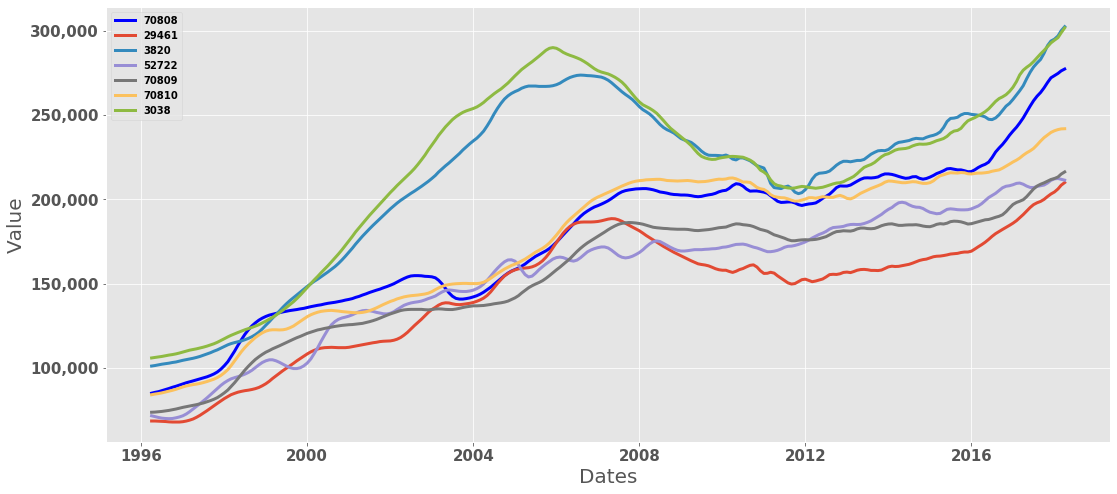

In [21]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8)) 
plt.grid(True) 
plt.xlabel('Dates', fontsize = 20) 
plt.xticks(fontsize = 15)
plt.ylabel('Value', fontsize = 20)
plt.yticks(fontsize = 15) 
plt.plot(melted_df_1['value'], linewidth = 3, color = 'blue', label = '70808')
plt.plot(melted_df_2['value'], linewidth = 3,  label = '29461')
plt.plot(melted_df_3['value'], linewidth = 3,  label = '3820')
plt.plot(melted_df_4['value'], linewidth = 3,  label = '52722')
plt.plot(melted_df_5['value'], linewidth = 3,  label = '70809')
plt.plot(melted_df_6['value'], linewidth = 3,  label = '70810')
plt.plot(melted_df_7['value'], linewidth = 3,  label = '3038')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.legend()
plt.show()

Below is a graph to show the probability distribution of price of our identified regions

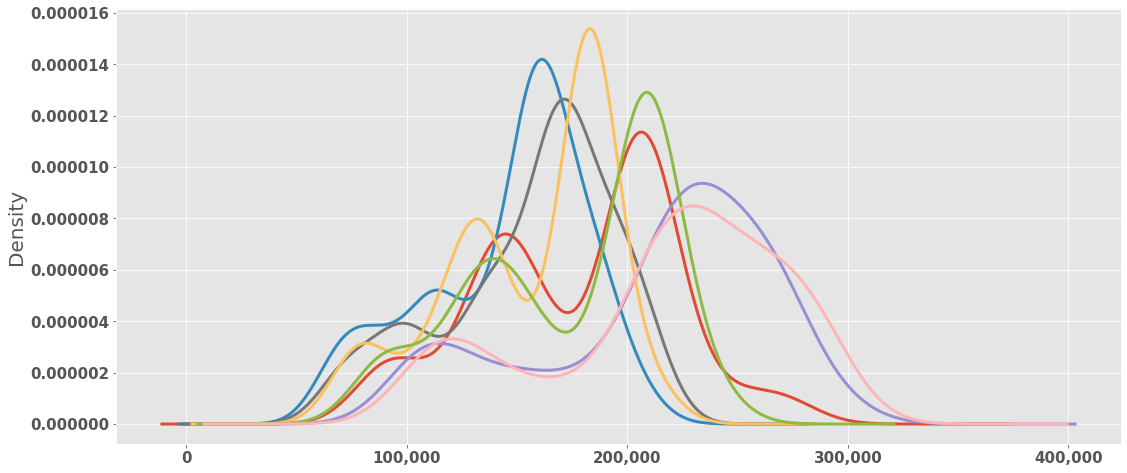

In [22]:
df_value_1 = melted_df_1['value'] 
df_value_1.plot(kind='kde',figsize = (18,8), linewidth= 3, label = '70808')
df_value_2 = melted_df_2['value'] 
df_value_2.plot(kind='kde',figsize = (18,8), linewidth= 3,  label = '29461') 
df_value_3 = melted_df_3['value'] 
df_value_3.plot(kind='kde',figsize = (18,8), linewidth= 3,  label = '3820') 
df_value_4 = melted_df_4['value'] 
df_value_4.plot(kind='kde',figsize = (18,8), linewidth= 3,  label = '52722') 
df_value_5 = melted_df_5['value'] 
df_value_5.plot(kind='kde',figsize = (18,8), linewidth= 3,  label = '70809')  
df_value_6 = melted_df_6['value'] 
df_value_6.plot(kind='kde',figsize = (18,8), linewidth= 3,  label = '70810')  
df_value_7 = melted_df_7['value'] 
df_value_7.plot(kind='kde',figsize = (18,8), linewidth= 3,  label = '3038')  
plt.xticks(fontsize = 15)
plt.grid("both")
plt.ylabel('Density', fontsize = 20)
plt.yticks(fontsize = 15)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

# Building the model

train test split

In [23]:
train_df_value_1=df_value_1[0:-int(len(df_value_1)*0.2)]
test_df_value_1=df_value_1[-int(len(df_value_1)*0.2):]

train_df_value_2=df_value_2[0:-int(len(df_value_2)*0.2)]
test_df_value_2=df_value_2[-int(len(df_value_2)*0.2):]

train_df_value_3=df_value_3[0:-int(len(df_value_3)*0.2)]
test_df_value_3=df_value_3[-int(len(df_value_3)*0.2):]

train_df_value_4=df_value_4[0:-int(len(df_value_4)*0.2)]
test_df_value_4=df_value_4[-int(len(df_value_4)*0.2):]

train_df_value_5=df_value_5[0:-int(len(df_value_5)*0.2)]
test_df_value_5=df_value_5[-int(len(df_value_5)*0.2):]

train_df_value_6=df_value_6[0:-int(len(df_value_6)*0.2)]
test_df_value_6=df_value_6[-int(len(df_value_6)*0.2):]

train_df_value_7=df_value_7[0:-int(len(df_value_7)*0.2)]
test_df_value_7=df_value_7[-int(len(df_value_7)*0.2):]



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


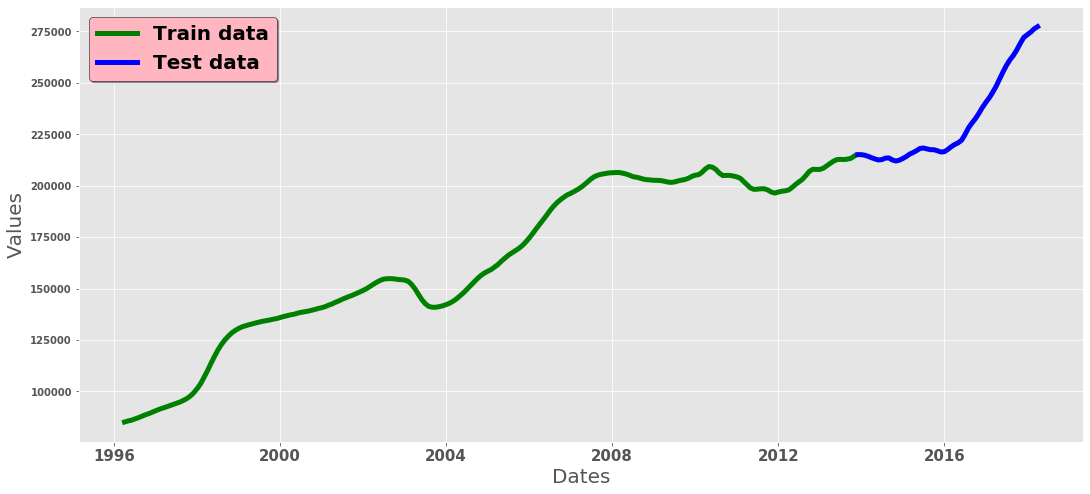

In [24]:

plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.ylabel('Values', fontsize = 20)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.plot(train_df_value_1, 'green', label='Train data', linewidth = 5)
plt.plot(test_df_value_1, 'blue', label='Test data', linewidth = 5)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')

## Check for stationarity


Time series analysis only works with stationary data, so we must first determine whether a series is stationary.
Stationary time series is when the mean and variance are constant over time. It is easier to predict when the series is stationary.

Time series models work on the assumption that the time series are stationary. For general time series datasets, if it shows a particular behavior over time, there is a very high probability that it will follow a similar behavior in the future.

1. The mean of the series should not be a function of time rather should be a constant. The image below has the left-hand graph satisfying the condition whereas the graph in red has a time-dependent mean.

2. The variance of the series should not be a function of time. This property is known as homoscedasticity. The following graph depicts what is and what is not a stationary series. (Notice the varying spread of distribution in the right-hand graph)

3. The covariance of the $i$th term and the $(i + m)$th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’ below.

### ADF (Augmented Dickey-Fuller) Test

I run a ADF test on each of the 7 zip codes to test for stationarity 

At first i could not understand the output of the adft. I had to search to find out what each value meant.

https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


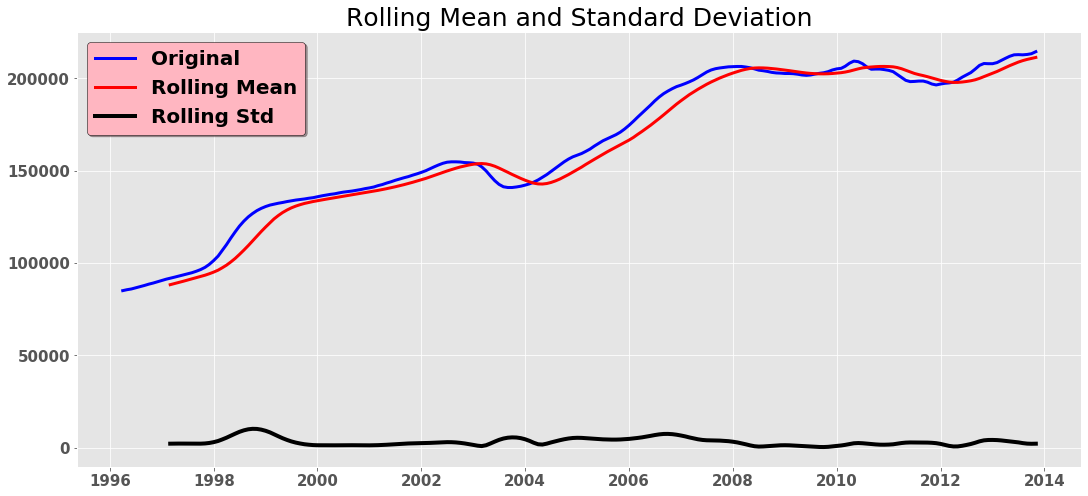

Results of dickey fuller test
Test Statistics                 -1.469114
p-value                          0.548731
No. of lags used                 3.000000
Number of observations used    208.000000
dtype: float64


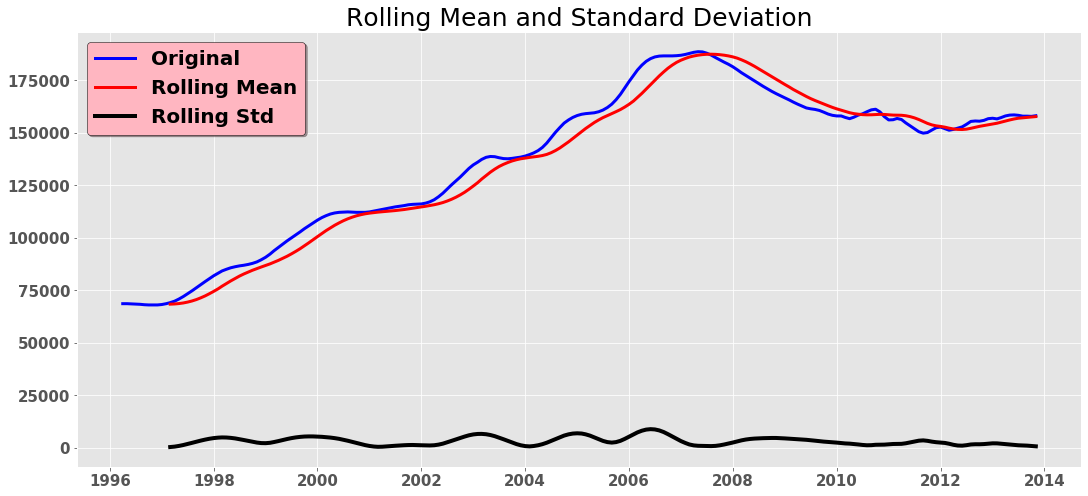

Results of dickey fuller test
Test Statistics                 -2.115483
p-value                          0.238334
No. of lags used                15.000000
Number of observations used    196.000000
dtype: float64


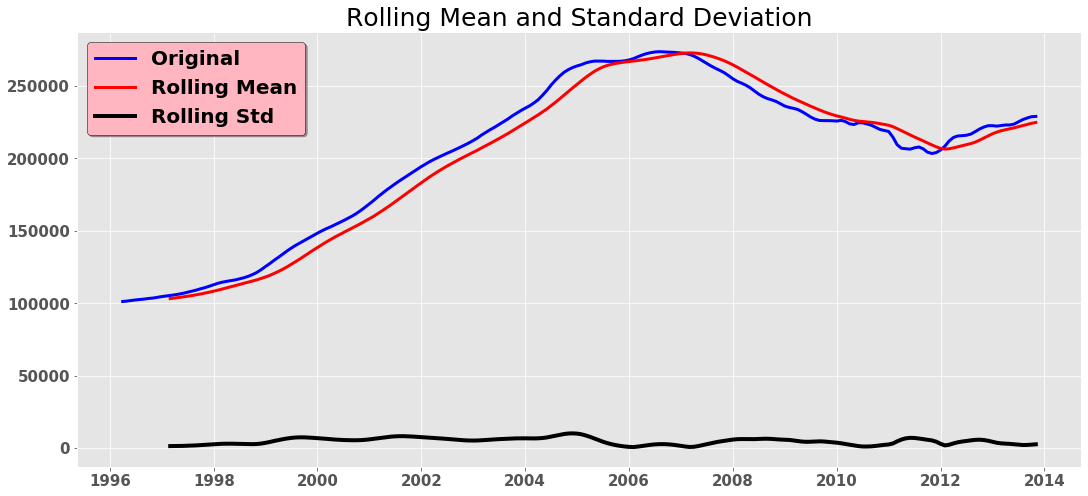

Results of dickey fuller test
Test Statistics                 -2.520082
p-value                          0.110664
No. of lags used                15.000000
Number of observations used    196.000000
dtype: float64


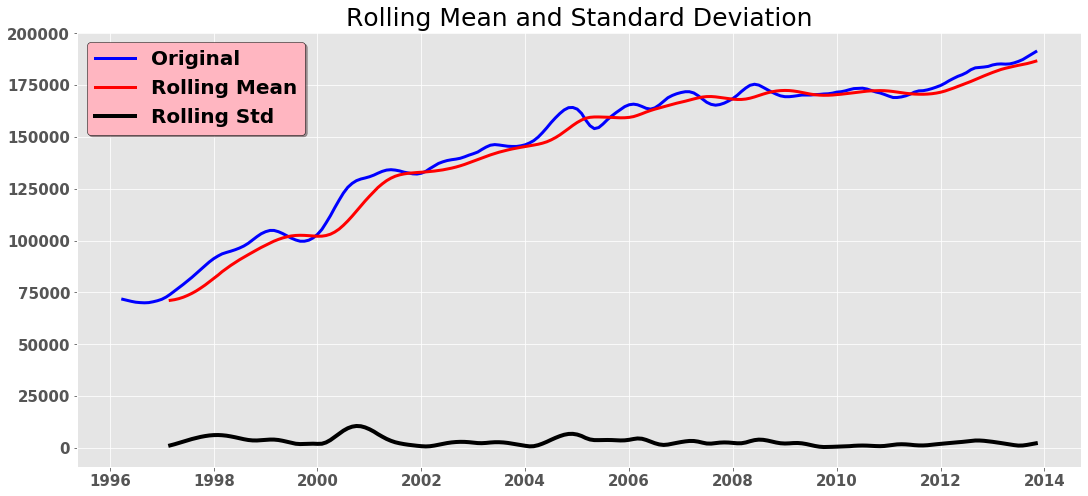

Results of dickey fuller test
Test Statistics                 -2.876942
p-value                          0.048096
No. of lags used                 5.000000
Number of observations used    206.000000
dtype: float64


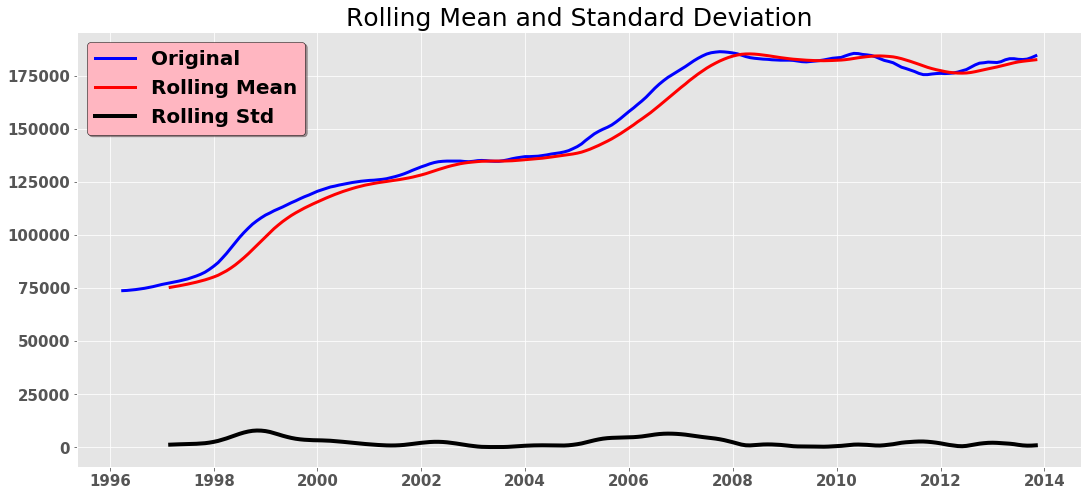

Results of dickey fuller test
Test Statistics                 -1.998326
p-value                          0.287308
No. of lags used                 5.000000
Number of observations used    206.000000
dtype: float64


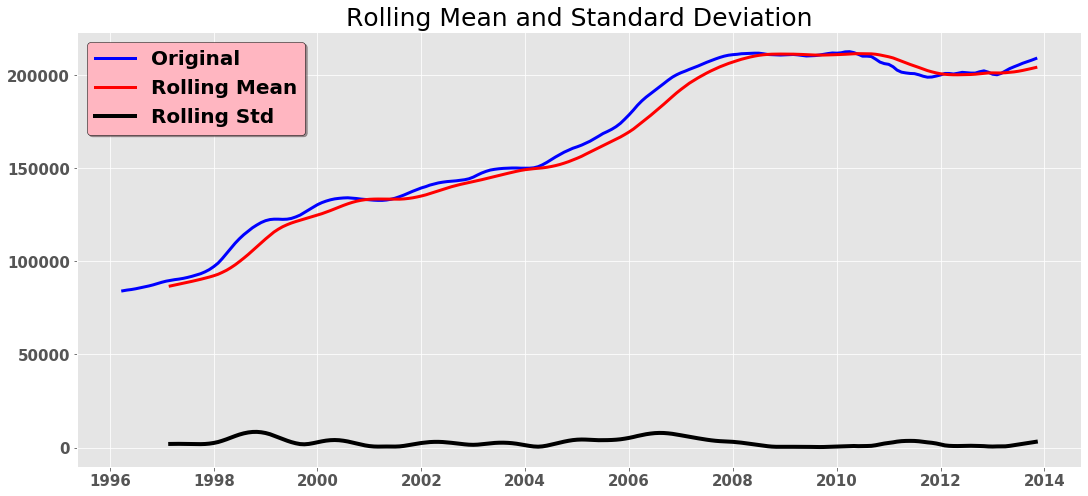

Results of dickey fuller test
Test Statistics                 -1.797809
p-value                          0.381550
No. of lags used                 5.000000
Number of observations used    206.000000
dtype: float64


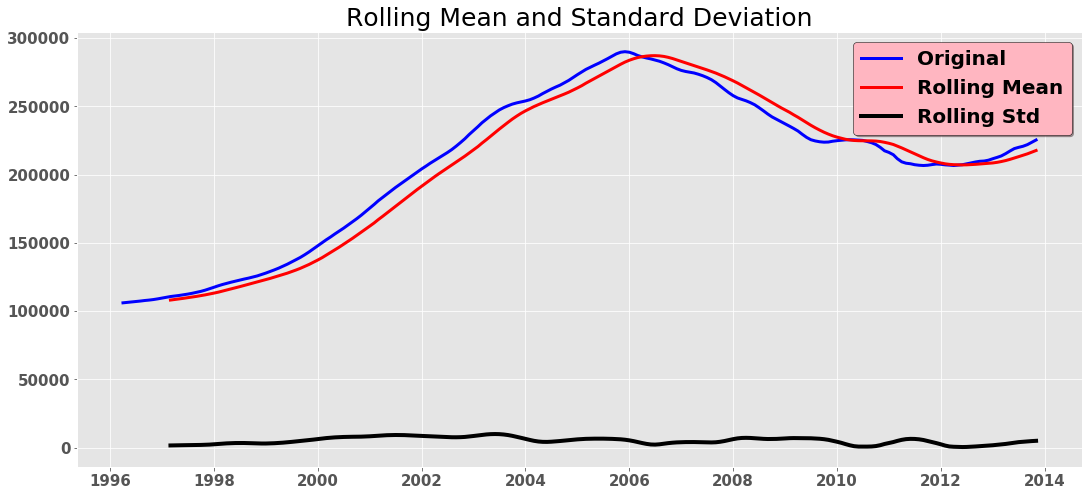

Results of dickey fuller test
Test Statistics                 -3.183492
p-value                          0.020960
No. of lags used                15.000000
Number of observations used    196.000000
dtype: float64


In [25]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std() 
    plt.figure(figsize = (18,8))
    plt.grid('both')
    plt.plot(timeseries, color='blue',label='Original', linewidth = 3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output)
    
test_stationarity(train_df_value_1)
test_stationarity(train_df_value_2)
test_stationarity(train_df_value_3)
test_stationarity(train_df_value_4)
test_stationarity(train_df_value_5)
test_stationarity(train_df_value_6)
test_stationarity(train_df_value_7)

df_value_1 -
not stationary - differencing needed

df_value_2 -
not stationary - differencing needed

df_value_3 -
not stationary - differencing needed

df_value_4 -
Stationary 

df_value_5 -
not stationary - differencing needed

df_value_6 -
not stationary - differencing needed

df_value_7 -
Stationary 

So for df_value_5 the order of differencing will be 0. For the test we must do differencing.


# Building model 1

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where: p is the number of autoregressive terms, d is the number of nonseasonal differences needed for stationarity, and. q is the number of lagged forecast errors in the prediction equation.

I need to find the p,d and q for each region. 

## Differencing

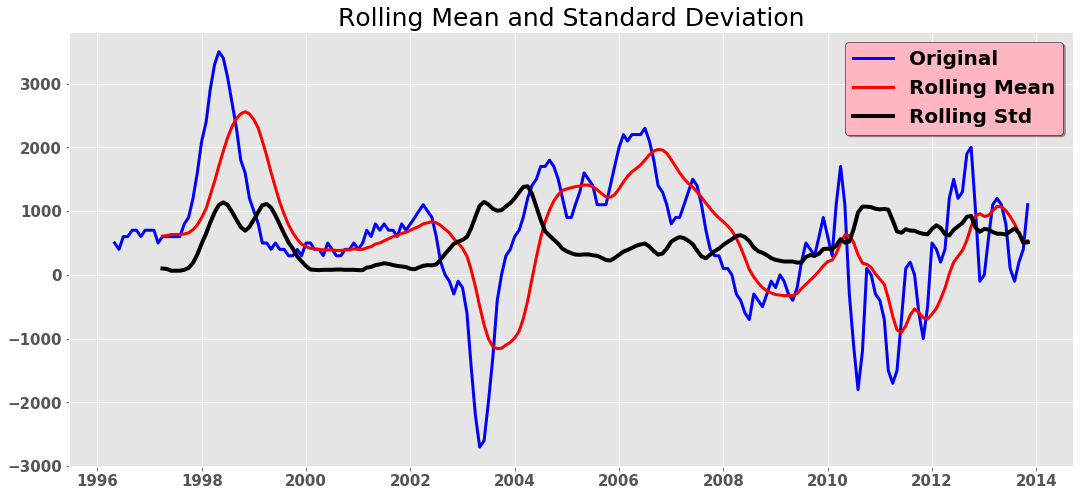

Results of dickey fuller test
Test Statistics                 -3.136660
p-value                          0.023956
No. of lags used                 2.000000
Number of observations used    208.000000
dtype: float64


In [26]:
# Get the difference of each Adj value point
train_value_diff_1 = train_df_value_1.diff()
train_value_diff_1.dropna(inplace=True)


test_stationarity(train_value_diff_1)


this is stationary after 1 order of differencing so that d value is 1

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

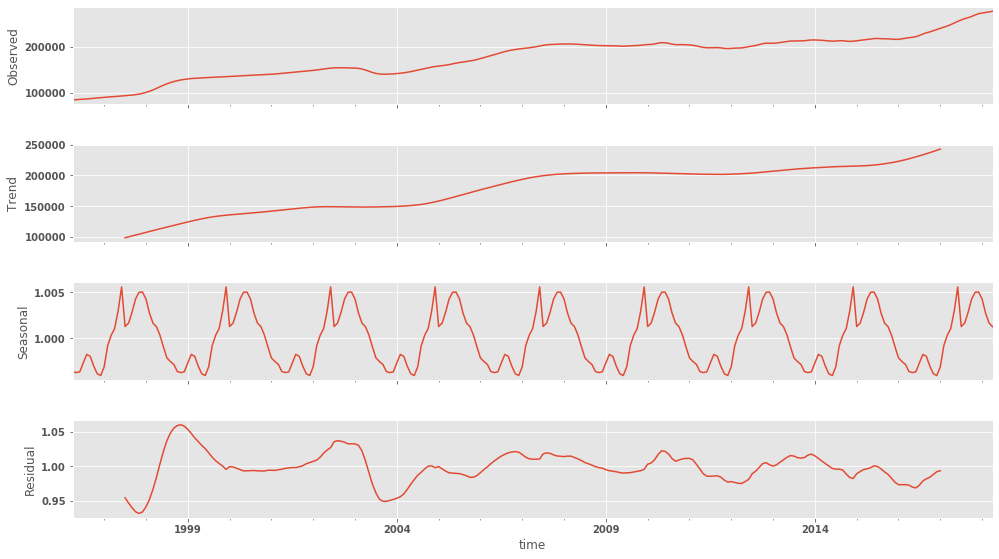

In [27]:
result = seasonal_decompose(df_value_1, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

this confirms that there is an element of seasonality and trend and shows that the residuals are not stationary 

## ACF and PACF

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR (auto regressive) or MA (moving average) terms are needed to correct any autocorrelation that remains in the differenced series.

Thus we use the ACF and PACF plots to determine to determine p and q values of our model.

tryign to understand trend and seasonality of the data. remove them. resiguals around 0 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


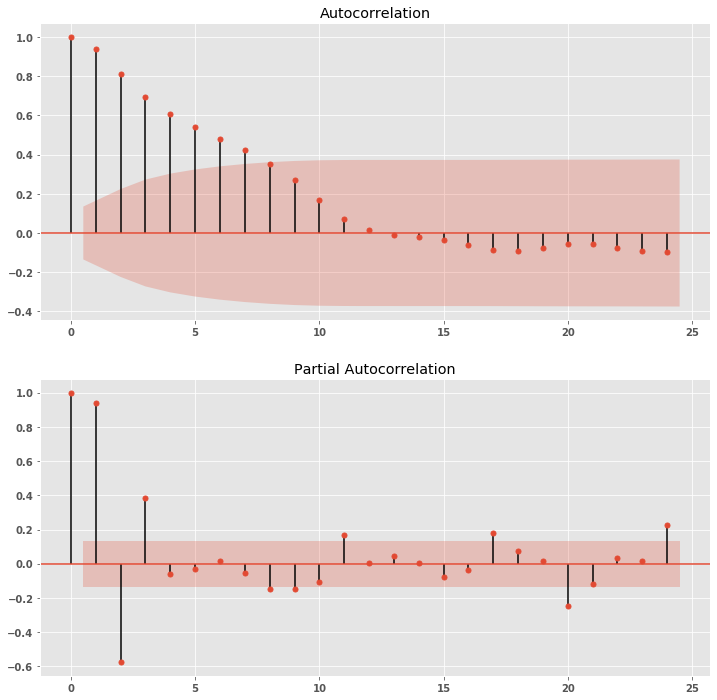

In [28]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_value_diff_1, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_value_diff_1, ax=ax2)

For ACF because it is so gradual we choose 0. The order (4,1,0) comes from the ACF and PACF plots. As doing one order differencing  made the values stationary so d value can be taken as 1, and after seeing the spikes below and above the confidene interval we can get p value as 4 and q value as 0.

# Step 5: ARIMA Modeling

Now we'll create an ARIMA model and train it using the train data's value. So, let’s visualize the data by dividing it into training and test sets.

This is the test train split 

In [29]:
history = [x for x in train_df_value_1]
predictions = list()
conf_list = list()
for t in range(len(test_df_value_1)):
    model = ARIMA(history,order=(4,1,0))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    conf_list.append(conf)
    history.append(test_df_value_1[t])


In [30]:
year1_1 = model_fit.forecast(steps=12)[0]
year5_1 = model_fit.forecast(steps=60)[0]
year10_1 = model_fit.forecast(steps=120)[0]

## results

difference between actuals and predictions added up - meand taken of then squarooted . we should compare this to the mean value of the property 

In [31]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_df_value_1, predictions)))

RMSE of ARIMA Model: 449.22071629960544


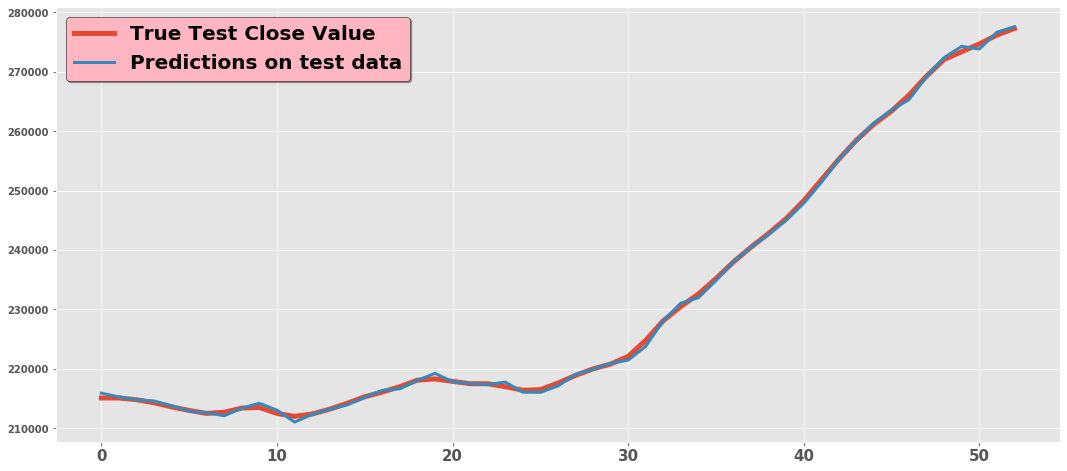

In [32]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_df_value_1)),test_df_value_1, label = 'True Test Close Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions on test data', linewidth =3)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

## Doing the same for all the other region ID's

# 2

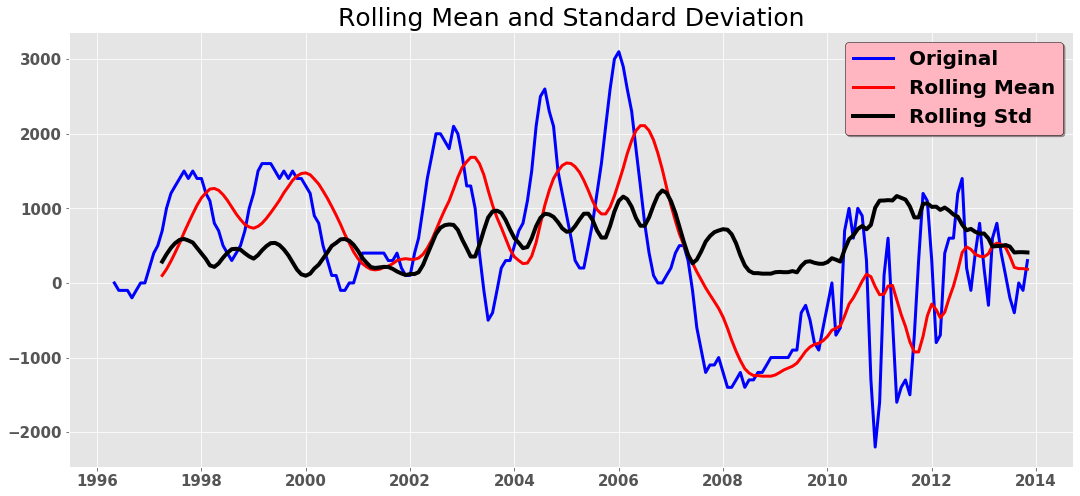

Results of dickey fuller test
Test Statistics                 -1.665252
p-value                          0.449099
No. of lags used                14.000000
Number of observations used    196.000000
dtype: float64


In [33]:
# Get the difference of each Adj value point
train_value_diff_2 = train_df_value_2.diff()
train_value_diff_2.dropna(inplace=True)


test_stationarity(train_value_diff_2)

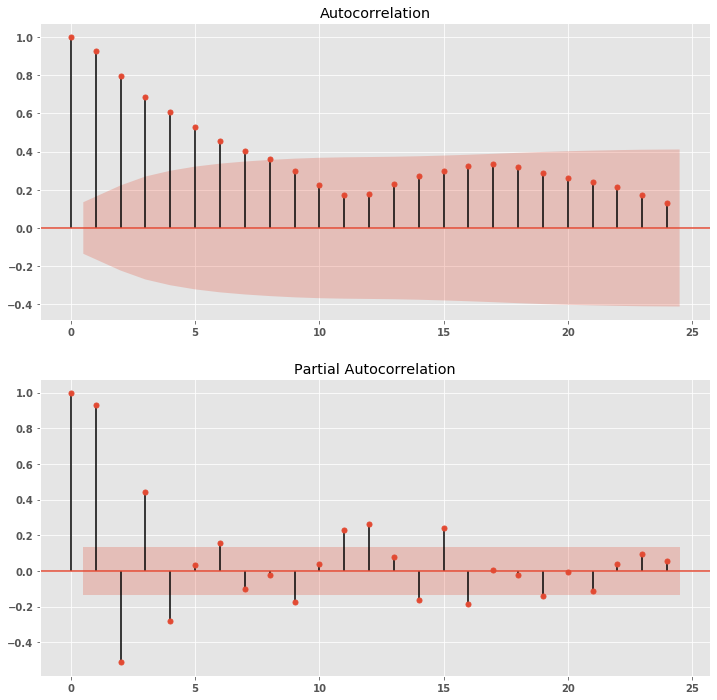

In [34]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_value_diff_2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_value_diff_2, ax=ax2)

so this would be (5,1,0)

In [35]:
history = [x for x in train_df_value_2]
predictions = list()
conf_list = list()
for t in range(len(test_df_value_2)):
    model = ARIMA(history,order=(5,1,0))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    conf_list.append(conf)
    history.append(test_df_value_2[t])

In [36]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_df_value_2, predictions)))

RMSE of ARIMA Model: 241.1294319304622


In [37]:
year1_2 = model_fit.forecast(steps=12)[0]
year5_2 = model_fit.forecast(steps=60)[0]
year10_2 = model_fit.forecast(steps=120)[0]

# 3

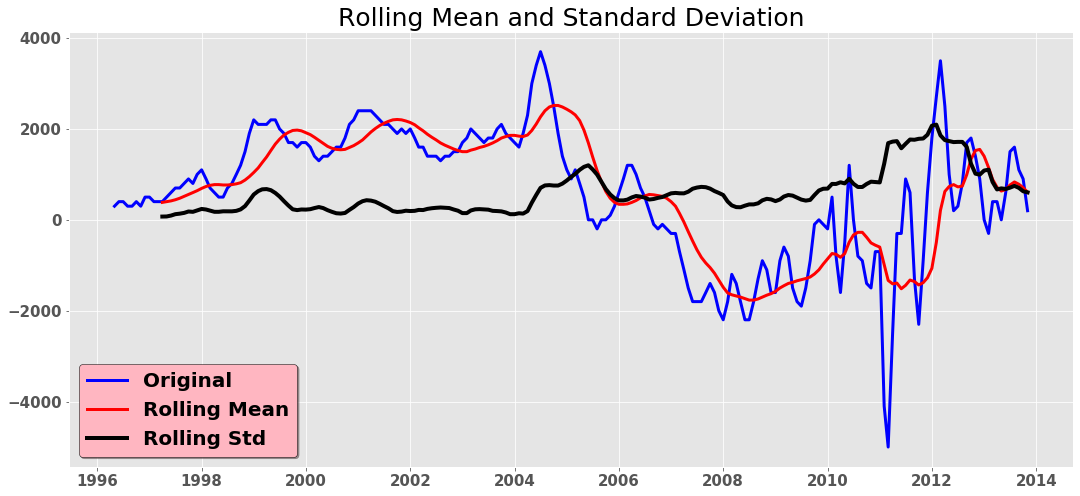

Results of dickey fuller test
Test Statistics                 -1.432930
p-value                          0.566391
No. of lags used                14.000000
Number of observations used    196.000000
dtype: float64


In [38]:
train_value_diff_3 = train_df_value_3.diff()
train_value_diff_3.dropna(inplace=True)


test_stationarity(train_value_diff_3)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


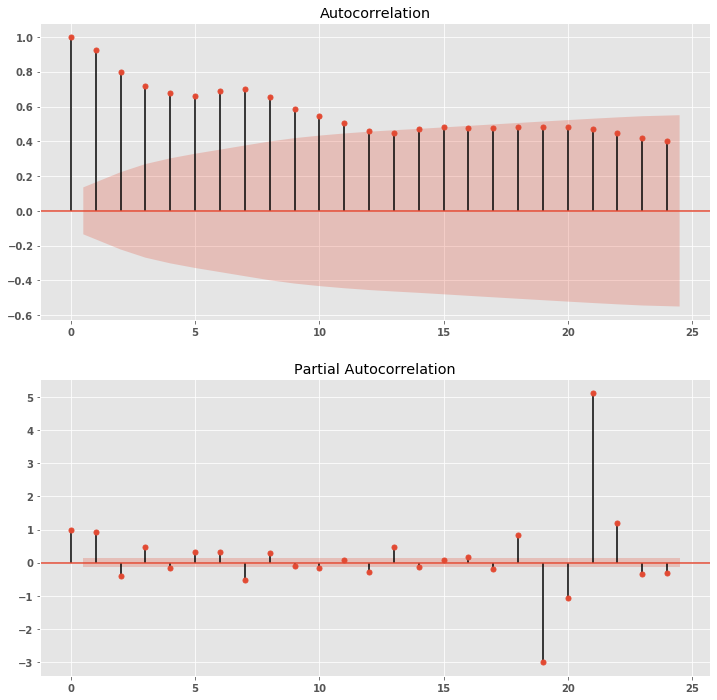

In [39]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_value_diff_3, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_value_diff_3, ax=ax2)

so this would be (4,1,0)

In [40]:
history = [x for x in train_df_value_3]
predictions = list()
conf_list = list()
for t in range(len(test_df_value_3)):
    model = ARIMA(history,order=(4,1,0))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    conf_list.append(conf)
    history.append(test_df_value_3[t])

In [41]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_df_value_3, predictions)))

RMSE of ARIMA Model: 638.3276601510468


In [42]:
year1_3 = model_fit.forecast(steps=12)[0]
year5_3 = model_fit.forecast(steps=60)[0]
year10_3 = model_fit.forecast(steps=120)[0]

# 4

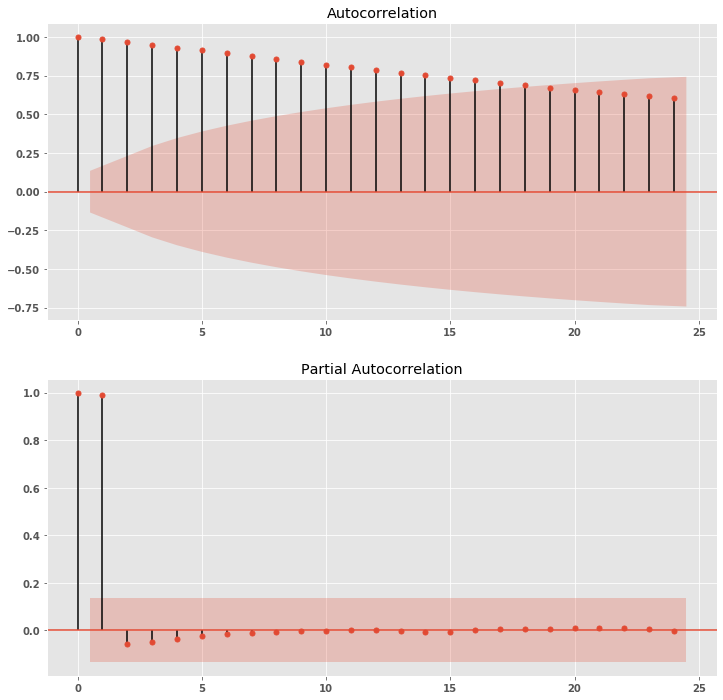

In [43]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_df_value_4, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_df_value_4, ax=ax2)

so this would be (2,0,0)

In [44]:
history = [x for x in train_df_value_4]
predictions = list()
conf_list = list()
for t in range(len(test_df_value_3)):
    model = ARIMA(history,order=(2,0,0))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    conf_list.append(conf)
    history.append(test_df_value_4[t])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fail

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian fa

In [45]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_df_value_4, predictions)))

RMSE of ARIMA Model: 492.61328986148925


In [46]:
year1_4 = model_fit.forecast(steps=12)[0]
year5_4 = model_fit.forecast(steps=60)[0]
year10_4 = model_fit.forecast(steps=120)[0]

# 5

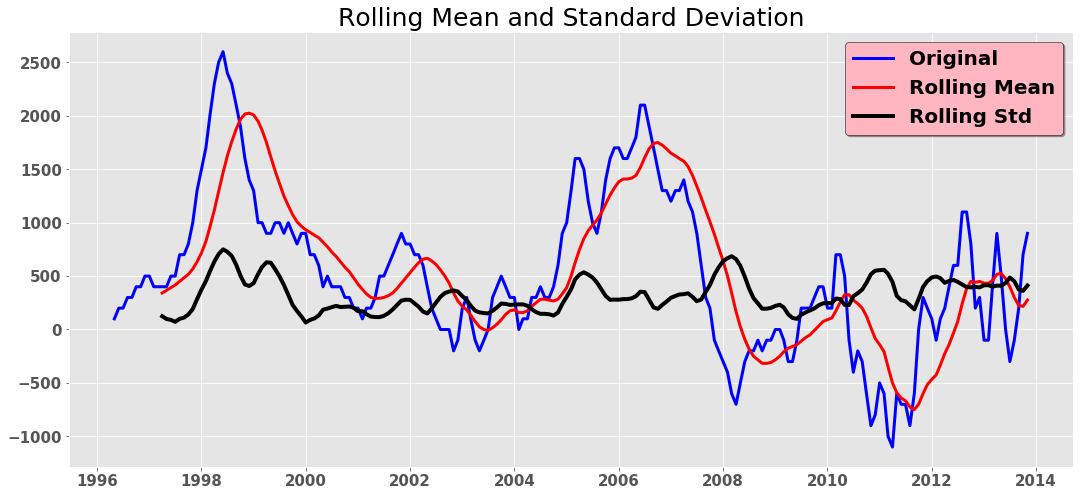

Results of dickey fuller test
Test Statistics                 -2.716159
p-value                          0.071284
No. of lags used                 4.000000
Number of observations used    206.000000
dtype: float64


In [47]:
train_value_diff_5 = train_df_value_5.diff()
train_value_diff_5.dropna(inplace=True)


test_stationarity(train_value_diff_5)

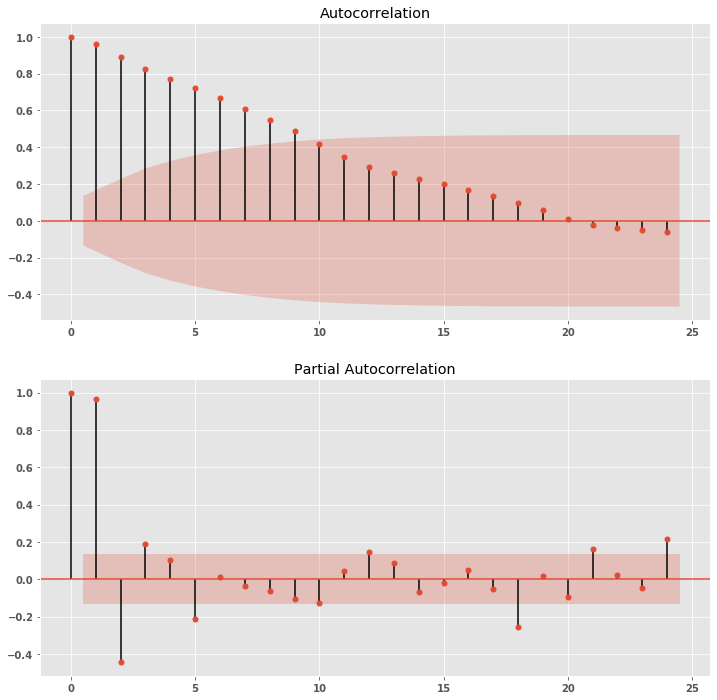

In [48]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_value_diff_5, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_value_diff_5, ax=ax2)

so this would be (4,1,0)

In [49]:
history = [x for x in train_df_value_5]
predictions = list()
conf_list = list()
for t in range(len(test_df_value_5)):
    model = ARIMA(history,order=(4,1,0))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    conf_list.append(conf)
    history.append(test_df_value_5[t])

In [50]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_df_value_5, predictions)))

RMSE of ARIMA Model: 366.16475984032706


In [51]:
year1_5 = model_fit.forecast(steps=12)[0]
year5_5 = model_fit.forecast(steps=60)[0]
year10_5 = model_fit.forecast(steps=120)[0]

# 6

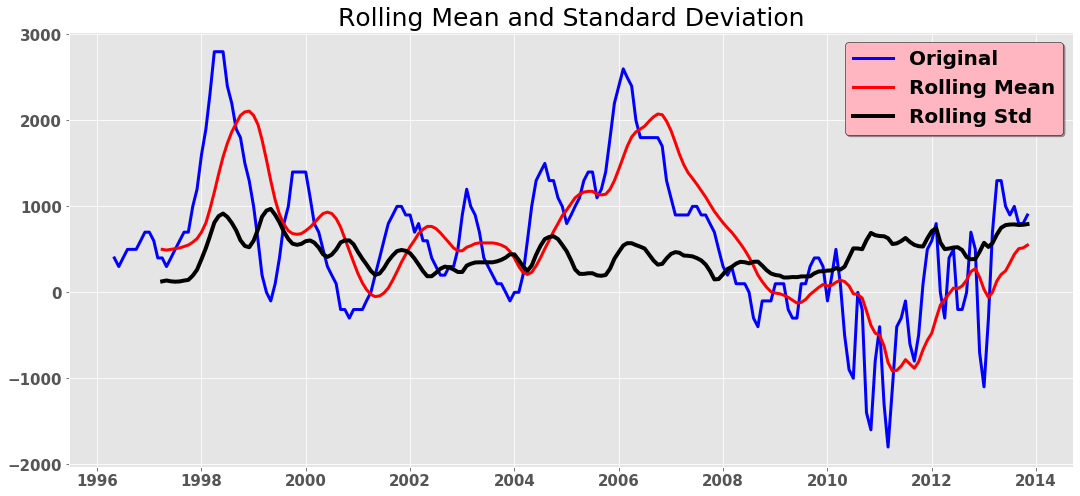

Results of dickey fuller test
Test Statistics                 -3.15179
p-value                          0.02295
No. of lags used                 4.00000
Number of observations used    206.00000
dtype: float64


In [52]:
train_value_diff_6 = train_df_value_6.diff()
train_value_diff_6.dropna(inplace=True)


test_stationarity(train_value_diff_6)

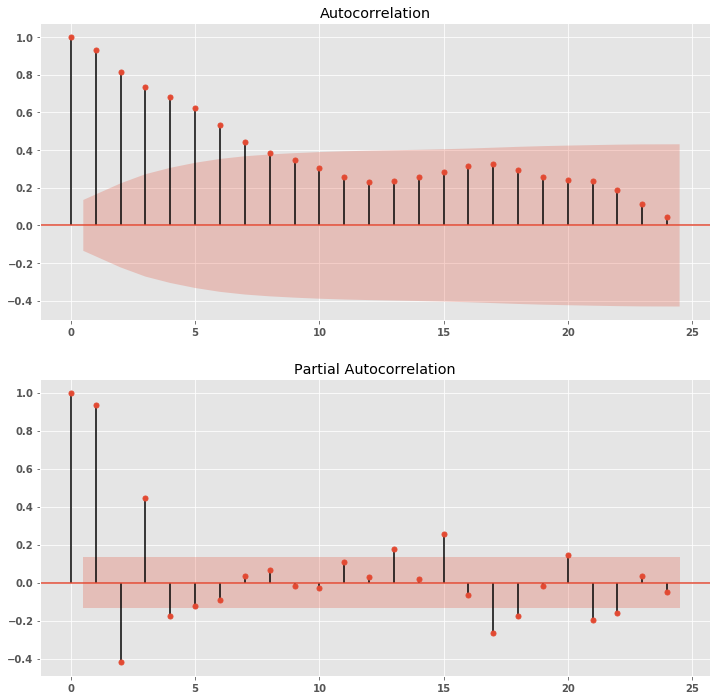

In [53]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_value_diff_6, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_value_diff_6, ax=ax2)

so this would be (6,1,0)

In [54]:
history = [x for x in train_df_value_6]
predictions = list()
conf_list = list()
for t in range(len(test_df_value_6)):
    model = ARIMA(history,order=(6,1,0))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    conf_list.append(conf)
    history.append(test_df_value_6[t])

In [55]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_df_value_6, predictions)))

RMSE of ARIMA Model: 315.9178921897554


In [56]:
year1_6 = model_fit.forecast(steps=12)[0]
year5_6 = model_fit.forecast(steps=60)[0]
year10_6 = model_fit.forecast(steps=120)[0]

# 7

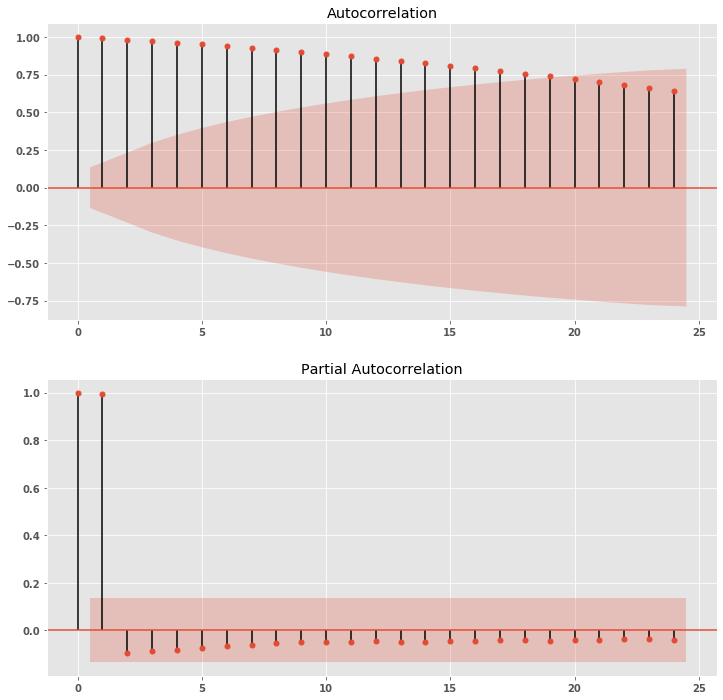

In [57]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_df_value_7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_df_value_7, ax=ax2)

so this would be (2,0,0)

In [58]:
history = [x for x in train_df_value_7]
predictions = list()
conf_list = list()
for t in range(len(test_df_value_7)):
    model = ARIMA(history,order=(2,0,1))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    conf_list.append(conf)
    history.append(test_df_value_7[t])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Max

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Max

In [59]:
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_df_value_7, predictions)))

RMSE of ARIMA Model: 488.77512816189943


In [60]:
year1_7 = model_fit.forecast(steps=12)[0]
year5_7 = model_fit.forecast(steps=60)[0]
year10_7 = model_fit.forecast(steps=120)[0]

# Forecasting

In [61]:
df = pd.DataFrame()
df['Zipcodes'] = ['70808','29461','3820','52722','70809','70810','3038']
df['1_year'] = [year1_1.mean(),year1_2.mean(),year1_3.mean(),year1_4.mean(),year1_5.mean(),year1_6.mean(),year1_7.mean()]
df['5_year'] = [year5_1.mean(),year5_2.mean(),year5_3.mean(),year5_4.mean(),year5_5.mean(),year5_6.mean(),year5_7.mean()]
df['10_year'] = [year10_1.mean(),year10_2.mean(),year10_3.mean(),year10_4.mean(),year10_5.mean(),year10_6.mean(),year10_7.mean()]

In [62]:
#Top 5 zipcodes to invest in
df.nlargest(5, '5_year')

,Zipcodes,1_year,5_year,10_year
2,3820,313565.547410,341523.696656,367843.792659
6,3038,317908.370538,336857.298310,318314.564017
0,70808,283501.516740,303345.689733,326052.890138
5,70810,243974.477459,256892.590916,274282.469535
4,70809,224538.705752,245297.378195,264466.382161


In [63]:
zc_best7.rename(columns={"RegionName": "Zipcodes1"}, inplace = True)
zc_best7

,Zipcodes1,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
1784,70808,85100.0,85600.0,86000.0,86600.0,87200.0,87900.0,88600.0,89200.0,89900.0,...,272100,273400,274700,276200,277300,266608.333333,2.258519,44668.407286,177707.547170,0.251359
1877,29461,68600.0,68600.0,68500.0,68400.0,68300.0,68100.0,68000.0,68000.0,68000.0,...,203200,204400,206200,208400,210000,201325.000000,2.061224,36155.846366,145173.207547,0.249053
2213,3820,101200.0,101500.0,101900.0,102300.0,102600.0,102900.0,103300.0,103600.0,104100.0,...,293900,295000,296900,300000,302400,287941.666667,1.988142,52962.689684,213244.905660,0.248366
1375,52722,71700.0,71200.0,70700.0,70300.0,70100.0,70000.0,70100.0,70500.0,71000.0,...,211300,212200,212400,211900,211400,209600.000000,1.948396,38100.881176,155742.264151,0.244641
2931,70809,73800.0,73900.0,74100.0,74300.0,74600.0,74900.0,75300.0,75700.0,76200.0,...,211800,212400,213300,215000,216300,209833.333333,1.930894,37182.278762,155364.150943,0.239323
1118,70810,84200.0,84600.0,84900.0,85300.0,85800.0,86300.0,86800.0,87400.0,88100.0,...,239700,240700,241400,241800,241900,236150.000000,1.872922,43695.226099,174863.396226,0.249882
2460,3038,106000.0,106300.0,106600.0,106900.0,107300.0,107700.0,108000.0,108400.0,108900.0,...,292800,294400,295900,298800,301700,289383.333333,1.846226,54038.230244,217384.528302,0.248584


In [64]:
join = zc_best7[['2018-04', 'Zipcodes1']].reset_index()
df = df.join(join)
df.drop(['Zipcodes1','index'], axis = 1, inplace = True)
df['ROI1'] = (df['1_year']/df['2018-04'])-1
df['ROI5'] = (df['5_year']/df['2018-04'])-1
df['ROI10'] = (df['10_year']/df['2018-04'])-1
df.nlargest(5, 'ROI5')

In [70]:
df1 = df.pop('2018-04')
df.insert(1, '2018-04', df1)
display(df)

,Zipcodes,2018-04,1_year,5_year,10_year,ROI1,ROI5,ROI10
0,70808,277300,283501.516740,303345.689733,326052.890138,0.022364,0.093926,0.175813
1,29461,210000,217651.321550,234251.153940,251438.758058,0.036435,0.115482,0.197327
2,3820,302400,313565.547410,341523.696656,367843.792659,0.036923,0.129377,0.216415
3,52722,211400,209320.859465,204568.831253,201374.183039,-0.009835,-0.032314,-0.047426
4,70809,216300,224538.705752,245297.378195,264466.382161,0.038089,0.134061,0.222683
5,70810,241900,243974.477459,256892.590916,274282.469535,0.008576,0.061978,0.133867
6,3038,301700,317908.370538,336857.298310,318314.564017,0.053723,0.116531,0.055070


In [71]:
df.drop(['ROI1', 'ROI5', 'ROI10'], axis = 1, inplace = True)

In [72]:
df.reset_index(drop=True, inplace=True)
df = df.T

In [73]:
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header

In [74]:
df

Zipcodes,70808,29461,3820,52722,70809,70810,3038
2018-04,277300,210000,302400,211400,216300,241900,301700
1_year,283502,217651,313566,209321,224539,243974,317908
5_year,303346,234251,341524,204569,245297,256893,336857
10_year,326053,251439,367844,201374,264466,274282,318315


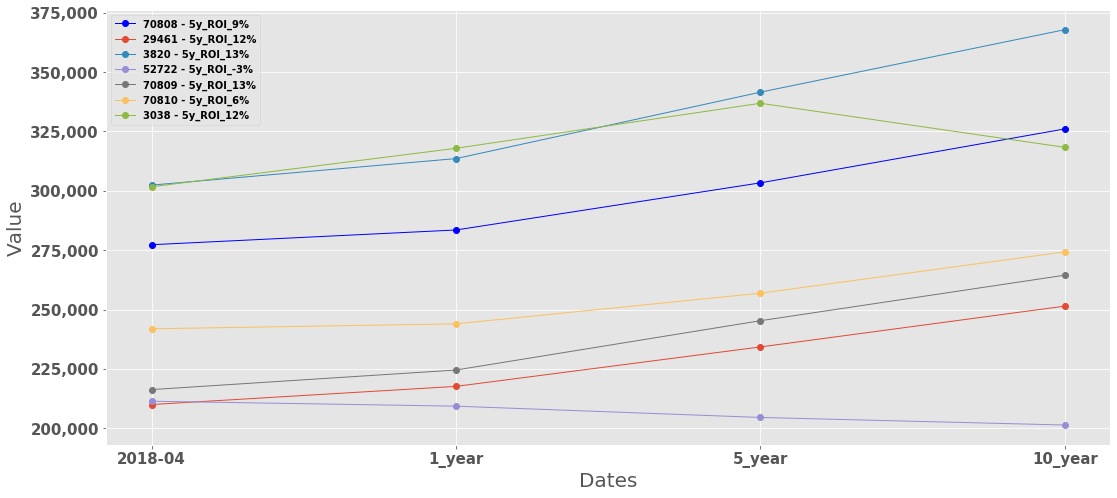

In [75]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8)) 
plt.grid(True) 
plt.xlabel('Dates', fontsize = 20) 
plt.xticks(fontsize = 15)
plt.ylabel('Value', fontsize = 20)
plt.yticks(fontsize = 15) 
plt.plot(df['70808'], linewidth = 1, color = 'blue', label = '70808 - 5y_ROI_9%', marker='o')
plt.plot(df['29461'], linewidth = 1, label = '29461 - 5y_ROI_12%', marker='o')
plt.plot(df['3820'], linewidth = 1, label = '3820 - 5y_ROI_13%', marker='o')
plt.plot(df['52722'], linewidth = 1, label = '52722 - 5y_ROI_-3%', marker='o')
plt.plot(df['70809'], linewidth = 1, label = '70809 - 5y_ROI_13%', marker='o')
plt.plot(df['70810'], linewidth = 1, label = '70810 - 5y_ROI_6%', marker='o')
plt.plot(df['3038'], linewidth = 1, label = '3038 - 5y_ROI_12%', marker='o')


current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.legend()
plt.show()



# Recommendations 

The Regions i would invest in, in order of preference are. 
1. 70809
2. 3820
3. 3038
4. 29461
5. 70808

This is because the ROI's for these 5 properties were highest after 5 years.

# Conclusion

1. We started of by explaing the project and 
2. We first analyzed the data. 
2. By filtering the data with specific criterias we came up with a subset of regions to analyze. 
3. We created a time series model on these regions and forecasted them into the future. 
4. We then calculated the ROI in the future and narrowed down the top 5. 

In the future if i had more time i would like to optimise on the following things:
1. Run a model that creates a time series model for every region.
2. Optimise on when to sell - perhaps there is a better timeframe as opposed to a fixed 5 year horizon (maybe it is predicted that some properties will peak after 6.7 years for example)
3. Optimise on features other than ROI
4. Loop more deeply at different property types (data provided)